<a href="https://colab.research.google.com/github/rootyJeon/deep_stat_study/blob/main/3%EC%A3%BC%EC%B0%A8_%ED%80%B4%EC%A6%88_%EC%A0%9C%EC%B6%9C%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 예제 코드

In [ ]:
import time
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        computation_time = end_time - start_time
        print(f"Execution time of {func.__name__}: {computation_time} seconds")
        return result
    return wrapper

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
lr = 0.1
epochs = 100
min_batch = 64

In [ ]:
import torch.utils.data as data
import torchvision as tv

train_dataset = tv.datasets.MNIST(".", download=True, train=True, transform=tv.transforms.ToTensor())
test_dataset = tv.datasets.MNIST(".", download=True, train=False, transform=tv.transforms.ToTensor())

In [ ]:
from torch.utils.data.dataloader import DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=min_batch, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=min_batch, shuffle=False)

In [ ]:
class DeepClassification(nn.Module):
    def __init__(self, hidden_variables=[128, 64, 10], input_output_dim=(28*28, 10)):
        super().__init__()
        # Concise Implementation
        self.input_variable_dim = input_output_dim[0]
        self.output_variable_dim = input_output_dim[1]
        self.list_hidden_variable = hidden_variables
        self.layer = nn.Sequential()

        variable_dim = self.input_variable_dim
        for i, hidden_variable in enumerate(self.list_hidden_variable):
            self.layer.add_module('layer_' + str(i), nn.Linear(variable_dim, hidden_variable))
            self.layer.add_module('custom_activation_' + str(i), nn.ReLU())
            variable_dim = hidden_variable
        self.layer.add_module('dropout_' + str(i), nn.Dropout(0.1))
        self.layer.add_module('final_layer', nn.Linear(variable_dim, self.output_variable_dim))

    def forward(self, x):
    # Computes the outputs / predictions
        x = x.view(-1, self.input_variable_dim)
        y_hat = self.layer(x)
        return y_hat

In [ ]:
def make_train_step(model, loss_fn, optimizer):
    def train_step_fn(x, y):

        model.train()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        return loss.item()
    return train_step_fn

In [ ]:
@timer
def train_model_classification(epochs=1000, eval_test_accuracy=False):

    def evaluate_step(x, y):
      y_hat = model(x)
      result = torch.sum(torch.argmax(y_hat, axis=1) == y)
      return result, len(y)

    train_losses = []
    test_accuracies = []
    for epoch in range(epochs):
        mini_batch_losses = []
        for x_minibatch, y_minibatch in train_loader:
            x_minibatch = x_minibatch.to(device)
            y_minibatch = y_minibatch.to(device)
            mini_batch_loss = train_step(x_minibatch, y_minibatch)
            mini_batch_losses.append(mini_batch_loss)

        if (epoch + 1) % 5 == 0:
            loss = np.mean(mini_batch_losses)
            print("train loss at {} epoch: {}".format(epoch + 1, round(loss, 10)))
            train_losses.append(loss)

            if eval_test_accuracy:
                with torch.no_grad():
                    test_accuracy = 0
                    test_result = 0
                    test_cnt = 0
                    for x_minibatch_test, y_minibatch_test in test_loader:
                        x_minibatch_test = x_minibatch_test.to(device)
                        y_minibatch_test = y_minibatch_test.to(device)
                        result, cnt = evaluate_step(x_minibatch_test, y_minibatch_test)
                        test_result += result
                        test_cnt += cnt
                    test_accuracy = 100 * test_result / test_cnt
                    print("test accuracy at {} epoch: {}%".format(epoch + 1, round(float(test_accuracy), 6)),"\n")
                    test_accuracies.append(float(test_accuracy))

            checkpoint = {'epochs': epochs,
                          'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizer.state_dict(),
                          'train_loss': train_losses,
                          'test_accuracy': test_accuracies
                          }
            torch.save(checkpoint, 'model_checkpoint.pth')


    return train_losses, test_accuracies

In [ ]:
model = DeepClassification().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_step = make_train_step(model, loss_fn, optimizer)
train_loss, test_accuracy = train_model_classification(epochs=100, eval_test_accuracy=True)

train loss at 5 epoch: 0.1543472597
test accuracy at 5 epoch: 94.800003% 

train loss at 10 epoch: 0.095420526
test accuracy at 10 epoch: 95.970001% 

train loss at 15 epoch: 0.0705635347
test accuracy at 15 epoch: 96.07% 

train loss at 20 epoch: 0.0569856289
test accuracy at 20 epoch: 96.559998% 

train loss at 25 epoch: 0.0427124471
test accuracy at 25 epoch: 97.050003% 

train loss at 30 epoch: 0.0344732376
test accuracy at 30 epoch: 97.050003% 

train loss at 35 epoch: 0.0268916556
test accuracy at 35 epoch: 96.910004% 

train loss at 40 epoch: 0.0250395505
test accuracy at 40 epoch: 97.220001% 

train loss at 45 epoch: 0.0177685137
test accuracy at 45 epoch: 97.489998% 

train loss at 50 epoch: 0.0170811058
test accuracy at 50 epoch: 97.459999% 

train loss at 55 epoch: 0.0199767074
test accuracy at 55 epoch: 97.470001% 

train loss at 60 epoch: 0.0151684663
test accuracy at 60 epoch: 97.519997% 

train loss at 65 epoch: 0.0170350749
test accuracy at 65 epoch: 97.449997% 

train 

In [ ]:
# Load Optimizer Parameters
checkpoint = torch.load('model_checkpoint.pth')
model = DeepClassification().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epochs']
train_loss = checkpoint['train_loss']
test_accuracy = checkpoint['test_accuracy']

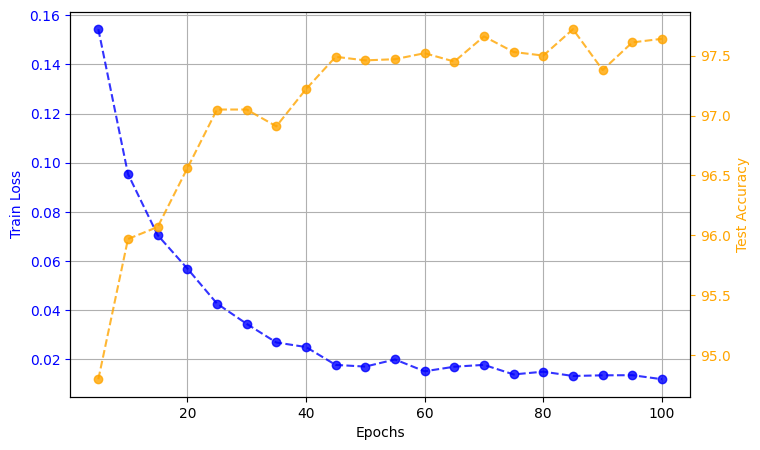

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

index = np.arange(5, 101, 5)

fig, ax1 = plt.subplots(figsize=(8, 5))
plt.grid(True)

ax1.plot(index, train_loss, color='b', linestyle='--', marker='o', alpha=0.8)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss', color='b')

ax2 = ax1.twinx()
ax2.plot(index, test_accuracy, color='orange',linestyle='--', marker='o', alpha=0.8)
ax2.set_ylabel('Test Accuracy', color='orange')

ax1.tick_params(axis='y', colors='b')
ax2.tick_params(axis='y', colors='orange')

plt.show()

### CIFAR-10 학습 시도

In [ ]:
from torchvision import datasets, transforms

transformer = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformer)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformer)

train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
training_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

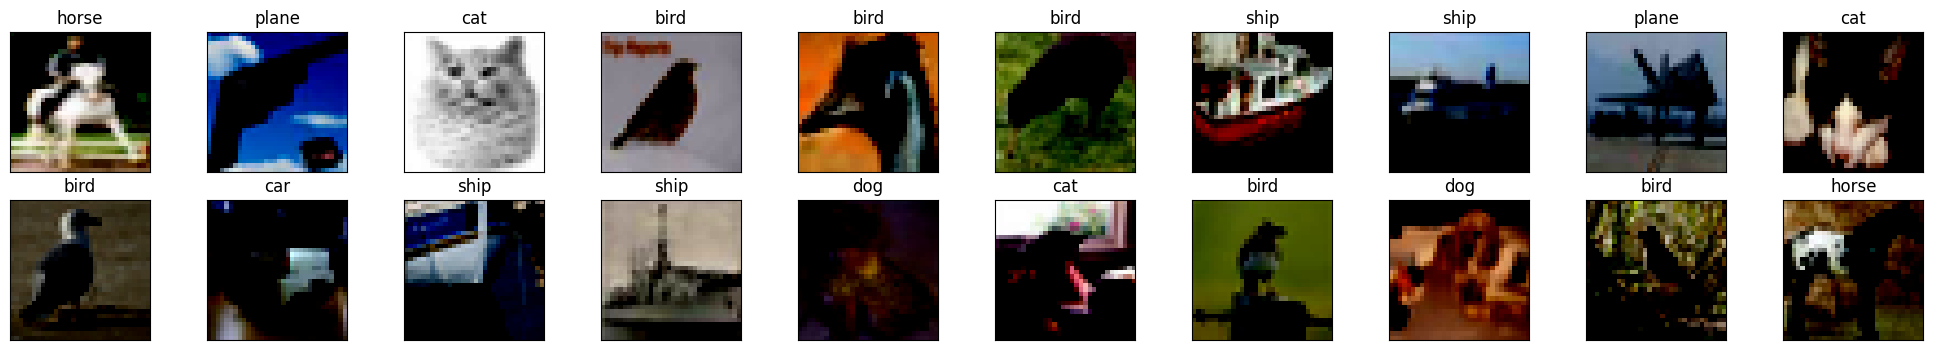

In [ ]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
  image = image.clip(0, 1)
  return image

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

dataiter = iter(train_loader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(25, 4))

for i in np.arange(20):
  # row 2 column 10
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[i]))
  ax.set_title(classes[labels[i].item()])

In [ ]:
accuracy_list = []
loss_list = []
for i in range(5):
  print(i+1,"번째 학습:")
  model = DeepClassification(input_output_dim=(32*32*3, 10)).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_step = make_train_step(model, loss_fn, optimizer)
  train_loss, test_accuracy = train_model_classification(epochs=20, eval_test_accuracy=True)

  loss_list.append(train_loss)
  accuracy_list.append(test_accuracy)
  print("")

print("평균 정확도: ", np.mean(np.array(accuracy_list)[:,len(accuracy_list[0])-1]))

1 번째 학습:
train loss at 5 epoch: 1.3872748895
test accuracy at 5 epoch: 48.34% 

train loss at 10 epoch: 1.2015219959
test accuracy at 10 epoch: 49.470001% 

train loss at 15 epoch: 1.0753712044
test accuracy at 15 epoch: 50.43% 

train loss at 20 epoch: 0.9670310738
test accuracy at 20 epoch: 50.150002% 

Execution time of train_model_classification: 535.0580596923828 seconds

2 번째 학습:
train loss at 5 epoch: 1.3885689716
test accuracy at 5 epoch: 48.080002% 

train loss at 10 epoch: 1.2007283496
test accuracy at 10 epoch: 49.970001% 

train loss at 15 epoch: 1.0705020959
test accuracy at 15 epoch: 50.349998% 

train loss at 20 epoch: 0.9714286042
test accuracy at 20 epoch: 50.439999% 

Execution time of train_model_classification: 537.2736520767212 seconds

3 번째 학습:
train loss at 5 epoch: 1.3903479097
test accuracy at 5 epoch: 48.060001% 

train loss at 10 epoch: 1.1991583446
test accuracy at 10 epoch: 50.099998% 

train loss at 15 epoch: 1.0672667248
test accuracy at 15 epoch: 48.7599

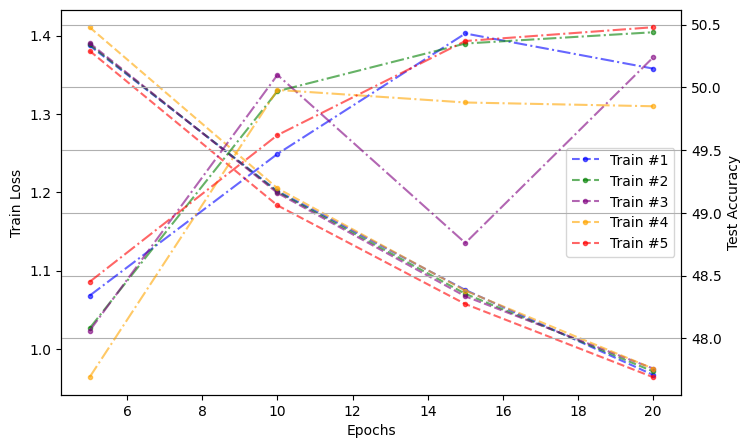

In [ ]:
losses = pd.DataFrame(loss_list, index=['Train Loss #1','Train Loss #2','Train Loss #3','Train Loss #4','Train Loss #5']).transpose()
accuracies = pd.DataFrame(accuracy_list, index=['Test Accuracy #1','Test Accuracy #2','Test Accuracy #3','Test Accuracy #4','Test Accuracy #5']).transpose()
colors = ['blue','green','purple','orange','red']

index = np.arange(5, 21, 5)

fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
plt.grid(True)

for i in range(len(losses.columns)):
  ax1.plot(index, losses[losses.columns[i]], color=colors[i], linestyle='--', marker='.', alpha=0.6, label='Train #'+str(i+1))
  ax2.plot(index, accuracies[accuracies.columns[i]], color=colors[i],linestyle='-.', marker='.', alpha=0.6)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss')
ax2.set_ylabel('Test Accuracy')
ax1.legend(loc='center right')
plt.show()

In [ ]:
!pip install torchviz

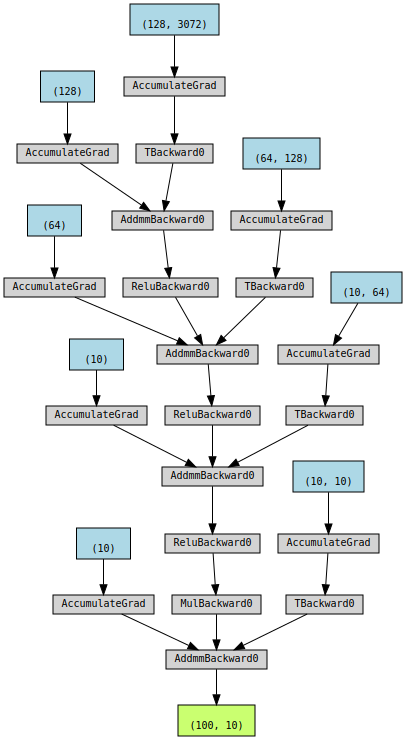

In [ ]:
from torchviz import make_dot
for x_minibatch, y_minibatch in train_loader:
  x_minibatch = x_minibatch.to(device)
  break
make_dot(model(x_minibatch))